# Data collection

ข้อมูลจะประกอบไปด้วย
* วันที่ (Date),
* ราคาเปิด (Open),
* ราคาสูงสุดของวัน (High),
* ราคาต่ำสุดของวัน (Low),
* ราคาปิด (Close),
* ราคาปิดที่ถูกปรับแล้ว (Adj Close), และ
* ปริมาณการซื้อขาย (Volume)


In [ ]:
import pandas as pd
import numpy as np
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.float_format','{:,.2f} '.format)

AOT: !gdown 1Ytf1couC1vtsPjvGNyo1XycGPM286Plh
PTTGC: !gdown 1uEH4sROglQjJHUi3wHX2ZYebc43eGTTo

Downloading...
From: https://drive.google.com/uc?id=1Ytf1couC1vtsPjvGNyo1XycGPM286Plh
To: /content/AOT.csv
100% 110k/110k [00:00<00:00, 87.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uEH4sROglQjJHUi3wHX2ZYebc43eGTTo
To: /content/PTTGC.csv
100% 111k/111k [00:00<00:00, 59.2MB/s]


In [ ]:
df_AOT = pd.read_csv('AOT.csv', index_col=False, parse_dates=['Date'])
df_AOT.set_index('Date', inplace=True)
df_AOT.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-04,63.25,64.50,63.00,64.00,47.71,14341900
2017-01-05,64.25,64.75,63.75,64.25,47.90,12762900
2017-01-06,64.50,64.50,63.75,64.00,47.71,8106700
2017-01-09,64.00,64.00,63.00,63.25,47.16,10983300
2017-01-10,63.00,63.50,62.75,63.50,47.34,8163200


# Case1: Use one dimension (single variable) and 1 step

In [ ]:
df1 = df_AOT.copy()
df1 = df1[['Close']]
df1.head()

,Close
Date,
2017-01-04,64.00
2017-01-05,64.25
2017-01-06,64.00
2017-01-09,63.25
2017-01-10,63.50


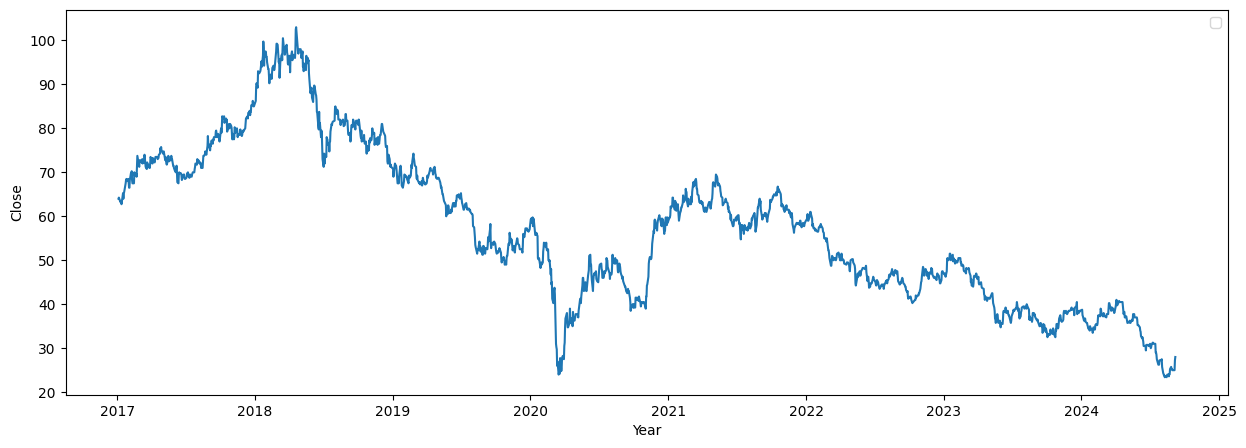

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df1.index, df1['Close'])
plt.xlabel('Year')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df1.index['2020:01:01':'2020:12:31'], df1['Close']['2020:01:01':'2020:12:31'])
plt.xlabel('Year')
plt.ylabel('Close')
plt.legend()
plt.show()

TypeError: slice indices must be integers or None or have an __index__ method

<Figure size 1500x500 with 0 Axes>

## Analize: Seasonal-Trend decomposition using LOESS (STL)


![](https://drive.google.com/uc?export=view&id=1to5WBNRxnO-25AVKZDAXxFj1-Purpxu9)

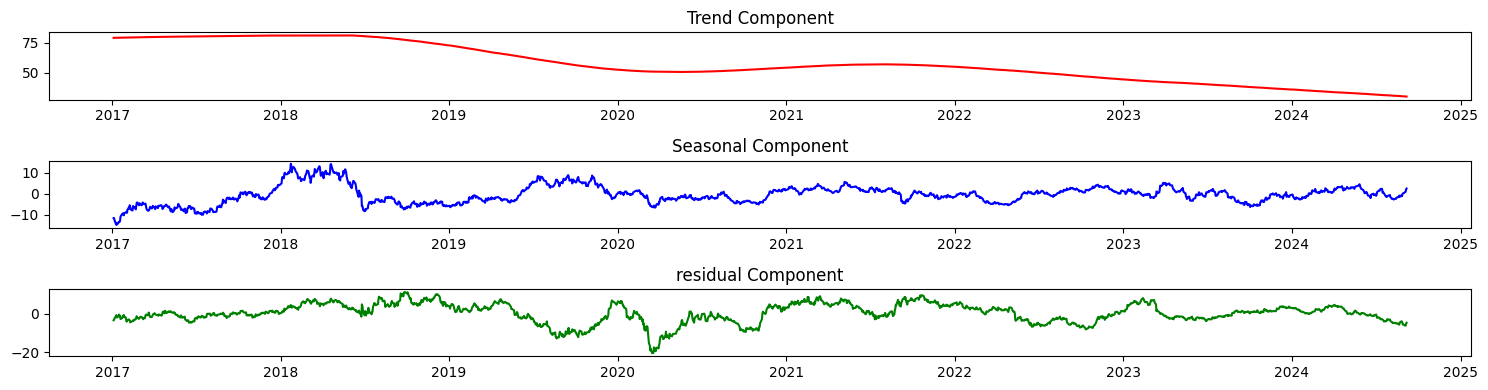

In [ ]:
#TSA
from statsmodels.tsa.seasonal import STL

stl = STL(df1['Close'], period=360)
result = stl.fit()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15,4))
ax1.set_title('Trend Component')
ax1.plot(df1.index, result.trend, label = 'Trend', color = 'red')
ax2.set_title('Seasonal Component')
ax2.plot(df1.index, result.seasonal, label = 'Seasonal', color = 'blue')
ax3.set_title('residual Component')
ax3.plot(df1.index, result.resid, label = 'residual', color = 'green')

plt.tight_layout()
plt.show()

#### Removing seasonal component

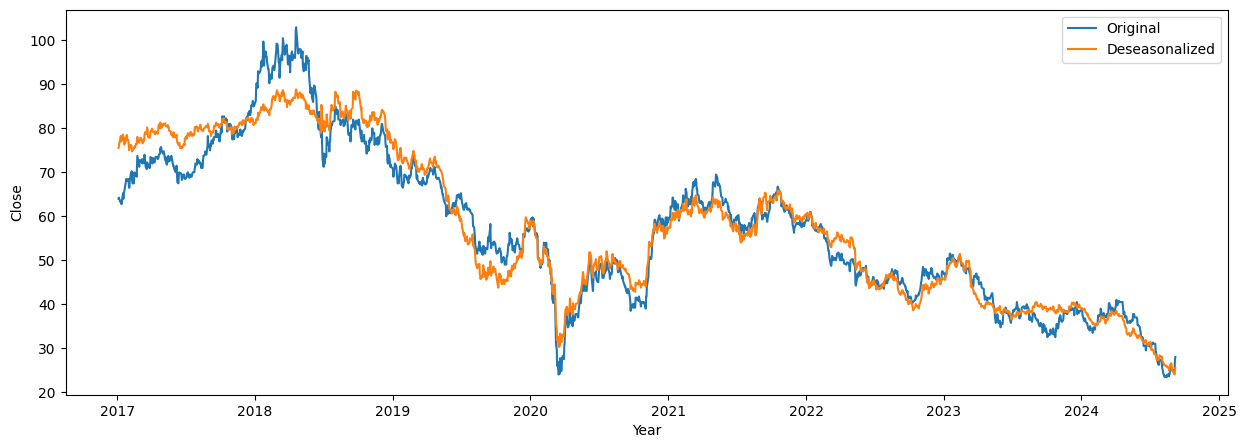

In [ ]:
# Create a deseasonalized time series
deseasonalized = df1['Close'] - result.seasonal

# visualize the comparative plot
plt.figure(figsize=(15,5))
plt.plot(df1.index, df1['Close'], label = 'Original')
plt.plot(df1.index, deseasonalized, label = 'Deseasonalized')
plt.xlabel('Year')
plt.ylabel('Close')
plt.legend()
plt.show()

#### Removing residual component

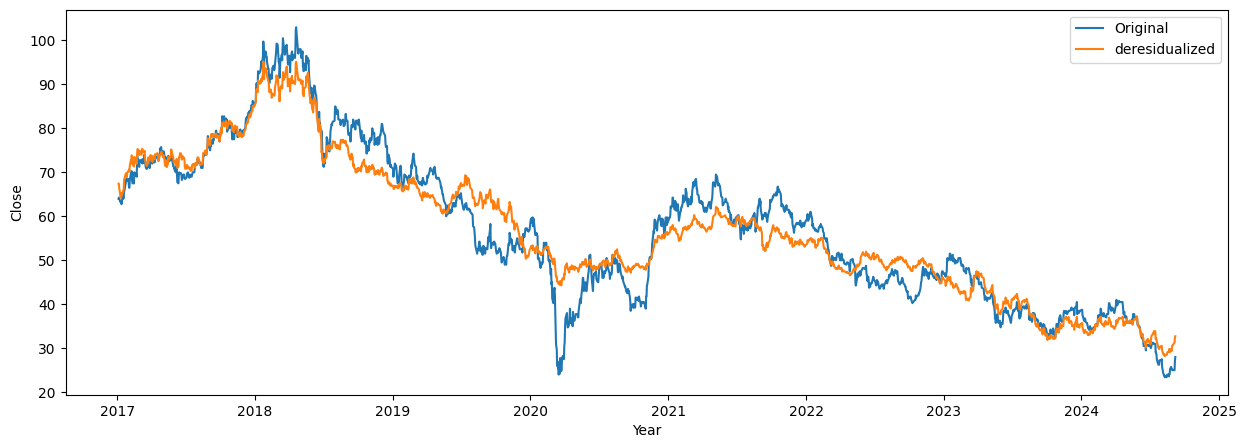

In [ ]:
# Create a deresidualized time series
deresidualized = df1['Close'] - result.resid

# visualize the comparative plot
plt.figure(figsize=(15,5))
plt.plot(df1.index, df1['Close'], label = 'Original')
plt.plot(df1.index, deresidualized, label = 'deresidualized')
plt.xlabel('Year')
plt.ylabel('Close')
plt.legend()
plt.show()


#### Removing trend component

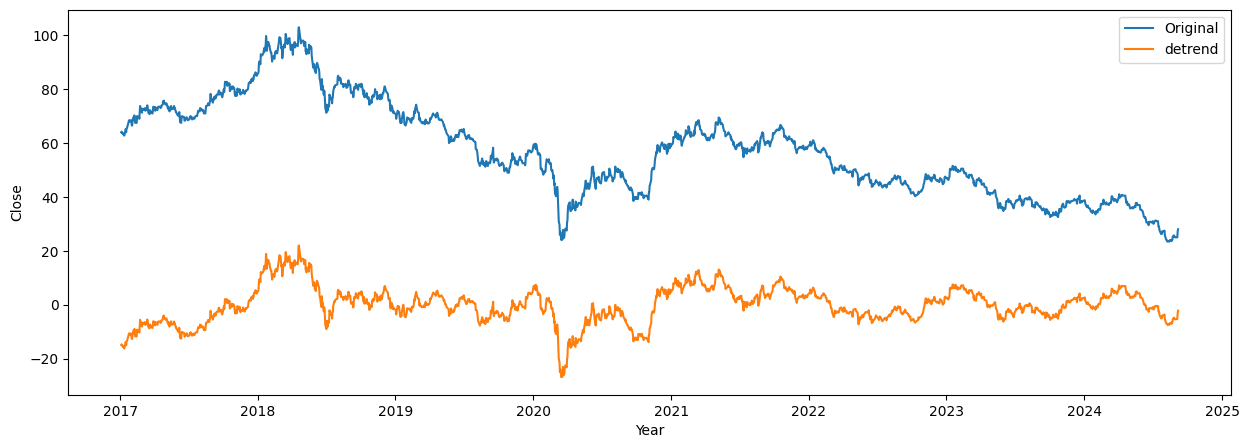

In [ ]:
# Create a detrend time series
detrend = df1['Close'] - result.trend

# visualize the comparative plot
plt.figure(figsize=(15,5))
plt.plot(df1.index, df1['Close'], label = 'Original')
plt.plot(df1.index, detrend, label = 'detrend')
plt.xlabel('Year')
plt.ylabel('Close')
plt.legend()
plt.show()


## Feature Engineering

### นำข้อมูลของวันถัดไป n วันมาต่อเพิ่ม column

<img src="https://miro.medium.com/max/700/1*lGPAbHRtK1TArAzB_6hzVQ.png"/>

In [ ]:
# Create lagged features
def create_lagged_features(df, windows=1, step=1):
    df_lagged = df.copy()
    for i in range(1, windows + step):
        df_lagged[f'day_{windows-i+step}'] = df['Close'].shift(i)
    df_lagged.dropna(inplace=True)
    df_lagged = df_lagged.iloc[:,::-1]
    return df_lagged.iloc[:, :-step].join(df_lagged[['Close']])

In [ ]:
windows = 5
df_lagged = create_lagged_features(df1, windows=windows)
df_lagged.head()

,day_1,day_2,day_3,day_4,day_5,Close
Date,,,,,,
2017-01-11,64.00,64.25,64.00,63.25,63.50,63.25
2017-01-12,64.25,64.00,63.25,63.50,63.25,62.75
2017-01-16,64.00,63.25,63.50,63.25,62.75,65.25
2017-01-17,63.25,63.50,63.25,62.75,65.25,64.00
2017-01-18,63.50,63.25,62.75,65.25,64.00,65.25


##Time Series Split


In [ ]:
#ข้อมูลสำหรับสร้างโมเดล
df_modeling = df_lagged.iloc[:-3, :]

#ข้อมูลสำหรับ AB testing
df_AB = df_lagged.iloc[-3:, :]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_modeling.drop('Close', axis=1),
    df_modeling['Close'], test_size=0.2,
    shuffle=False)



##Modeling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

RMSE : 10.276479514312255
R2 : -2.91002882444392


<Axes: ylabel='Close'>

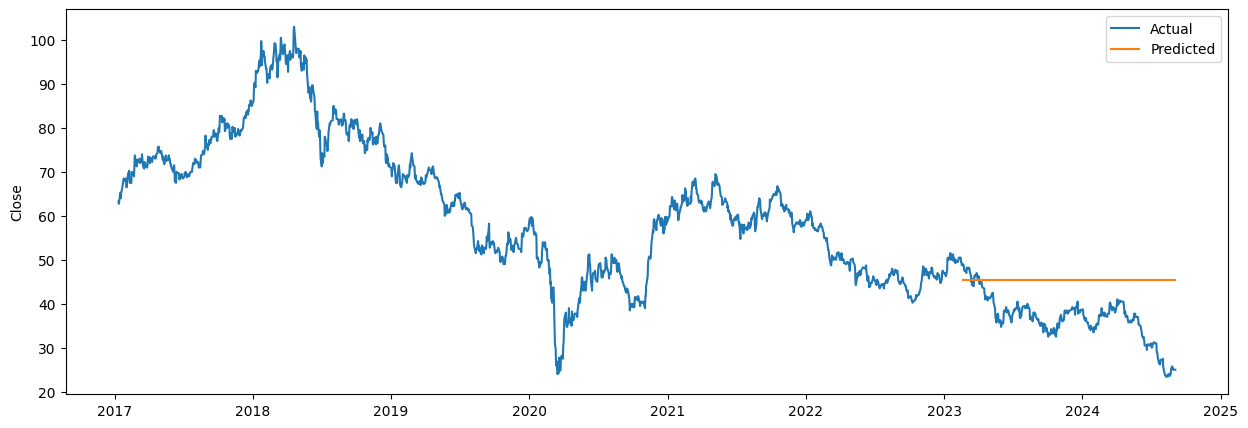

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)

model  = RandomForestRegressor(n_estimators=500, max_depth =2, random_state=0)
model = TransformedTargetRegressor(regressor=model, transformer=MinMaxScaler())
model.fit(scaler.transform(X_train), y_train)
y_pred = model.predict(scaler.transform(X_test))

print('RMSE :', mean_squared_error(y_test, y_pred, squared=True)**0.5)
# print('MAE :', mean_absolute_error(y_test, y_pred))
# print('MAPE :', mean_absolute_percentage_error(y_test, y_pred))
print('R2 :', r2_score(y_test, y_pred))

pred_df = pd.DataFrame({'Date': X_test.index.values, 'Predicted': y_pred})
pred_df.set_index('Date', inplace=True)

plt.figure(figsize=(15,5))
sns.lineplot(x=df_modeling.index.values,
             y=df_modeling['Close'],
             label='Actual')

sns.lineplot(x=pred_df.index.values,
             y=pred_df['Predicted'],
             label='Predicted')

RMSE : 4.902345517872274
R2 : 0.11018633379961706


<Axes: ylabel='Close'>

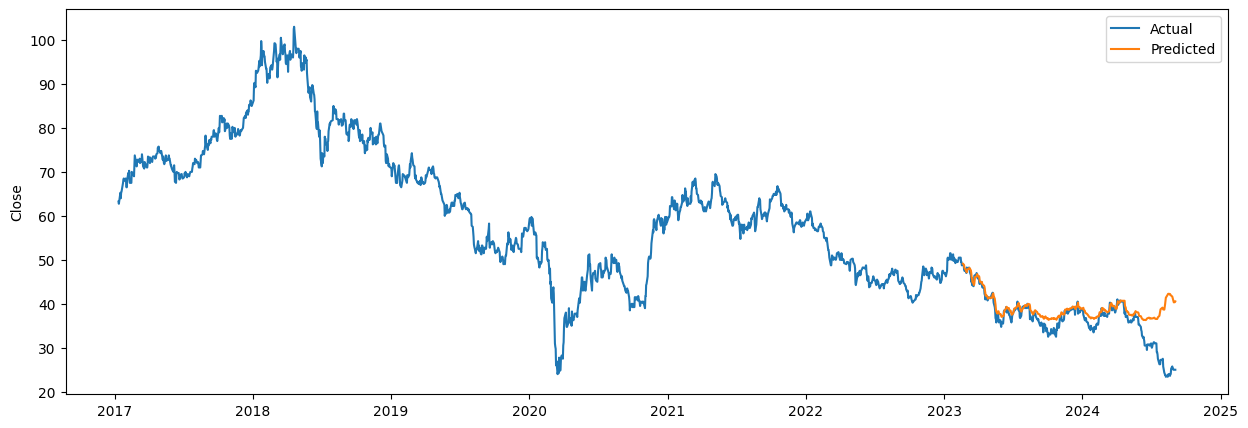

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)

model  = SVR()
model.fit(scaler.transform(X_train), y_train)
y_pred = model.predict(scaler.transform(X_test))

print('RMSE :', mean_squared_error(y_test, y_pred, squared=True)**0.5)
# print('MAE :', mean_absolute_error(y_test, y_pred))
# print('MAPE :', mean_absolute_percentage_error(y_test, y_pred))
print('R2 :', r2_score(y_test, y_pred))

pred_df = pd.DataFrame({'Date': X_test.index.values, 'Predicted': y_pred})
pred_df.set_index('Date', inplace=True)

plt.figure(figsize=(15,5))
sns.lineplot(x=df_modeling.index.values,
             y=df_modeling['Close'],
             label='Actual')

sns.lineplot(x=pred_df.index.values,
             y=pred_df['Predicted'],
             label='Predicted')

RMSE : 0.7031130733838491
R2 : 0.9816961864377773


<Axes: ylabel='Close'>

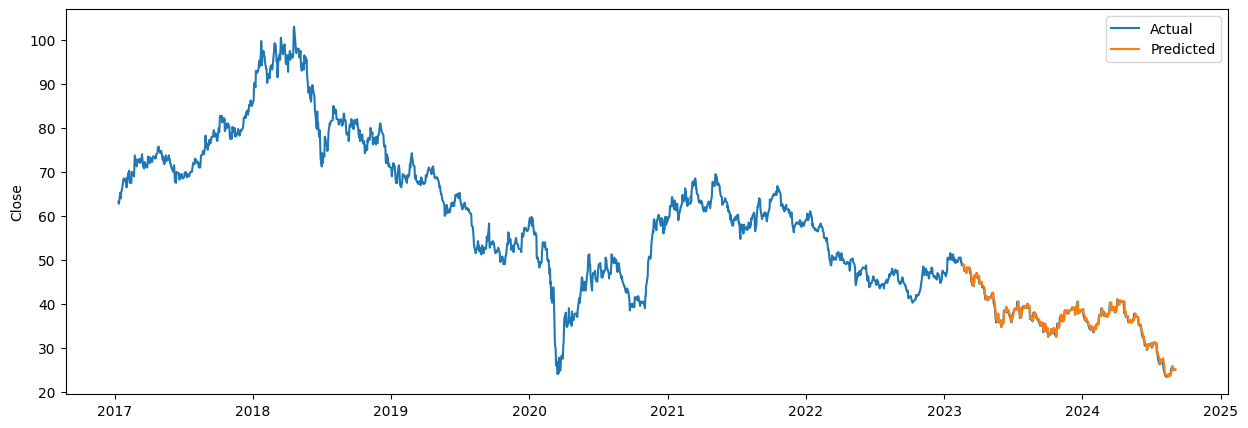

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)

model  = LinearRegression()
model.fit(scaler.transform(X_train), y_train)
y_pred = model.predict(scaler.transform(X_test))

print('RMSE :', mean_squared_error(y_test, y_pred, squared=True)**0.5)
# print('MAE :', mean_absolute_error(y_test, y_pred))
# print('MAPE :', mean_absolute_percentage_error(y_test, y_pred))
print('R2 :', r2_score(y_test, y_pred))

pred_df = pd.DataFrame({'Date': X_test.index.values, 'Predicted': y_pred})
pred_df.set_index('Date', inplace=True)

plt.figure(figsize=(15,5))
sns.lineplot(x=df_modeling.index.values,
             y=df_modeling['Close'],
             label='Actual')

sns.lineplot(x=pred_df.index.values,
             y=pred_df['Predicted'],
             label='Predicted')

## Predict Future data

In [ ]:
future_data = df_AB.iloc[[0], :-1]
future_data

,day_1,day_2,day_3,day_4,day_5
Date,,,,,
2024-09-04,25.25,25.00,25.00,25.00,25.00


In [ ]:
y_pred = model.predict(scaler.transform(future_data.values.reshape(1,-1)))

# print('RMSE :', mean_squared_error(y_test, y_pred, squared=True)**0.5)
# # print('MAE :', mean_absolute_error(y_test, y_pred))
# # print('MAPE :', mean_absolute_percentage_error(y_test, y_pred))
# print('R2 :', r2_score(y_test, y_pred))

print('Actual', df_AB.iloc[[0],[-1]].values)
print('Predicted', y_pred[0])


Actual [[25.]]
Predicted 25.08386449117342


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# Case2: Use one dimension (single variable) and multi-step

In [ ]:
df2 = df_AOT.copy()
df2.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-04,63.25,64.50,63.00,64.00,47.71,14341900
2017-01-05,64.25,64.75,63.75,64.25,47.90,12762900
2017-01-06,64.50,64.50,63.75,64.00,47.71,8106700
2017-01-09,64.00,64.00,63.00,63.25,47.16,10983300
2017-01-10,63.00,63.50,62.75,63.50,47.34,8163200


# Case3: create new dimensions (multiple variable)




## Feature Engineering

### Extract time series variable

In [ ]:
# Extract time series variable
df2['Year'] = df2.index.year
df2['Month'] = df2.index.month
df2['Day'] = df2.index.day
df2['weekday'] = df2.index.strftime('%a')

# Set categorical variable
df2 = df2.astype({'Year':'category',
                  'Month':'category',
                  'Day':'category',
                  'weekday':'category'})
df2.head()

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,weekday
Date,,,,,,,,,,
2017-01-04,63.25,64.50,63.00,64.00,47.71,14341900,2017,1,4,Wed
2017-01-05,64.25,64.75,63.75,64.25,47.90,12762900,2017,1,5,Thu
2017-01-06,64.50,64.50,63.75,64.00,47.71,8106700,2017,1,6,Fri
2017-01-09,64.00,64.00,63.00,63.25,47.16,10983300,2017,1,9,Mon
2017-01-10,63.00,63.50,62.75,63.50,47.34,8163200,2017,1,10,Tue


###Incorporate previous day price and volume features

In [ ]:
window = 7
df2['pv_high'] = df2['High'].shift(periods = window, fill_value = 0)
df2['pv_low'] = df2['Low'].shift(periods = window, fill_value = 0)
df2['pv_volume'] = df2['Volume'].shift(periods = window, fill_value = 0)
df2.head(5)

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,weekday,pv_high,pv_low,pv_volume
Date,,,,,,,,,,,,,
2017-01-04,63.25,64.50,63.00,64.00,47.71,14341900,2017,1,4,Wed,0.00,0.00,0
2017-01-05,64.25,64.75,63.75,64.25,47.90,12762900,2017,1,5,Thu,0.00,0.00,0
2017-01-06,64.50,64.50,63.75,64.00,47.71,8106700,2017,1,6,Fri,0.00,0.00,0
2017-01-09,64.00,64.00,63.00,63.25,47.16,10983300,2017,1,9,Mon,0.00,0.00,0
2017-01-10,63.00,63.50,62.75,63.50,47.34,8163200,2017,1,10,Tue,0.00,0.00,0


In [ ]:
df2.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace = True)

In [ ]:
df2

,Year,Month,Day,weekday,pv_high,pv_low,pv_volume
Date,,,,,,,
2017-01-04,2017,1,4,Wed,0.00,0.00,0
2017-01-05,2017,1,5,Thu,0.00,0.00,0
2017-01-06,2017,1,6,Fri,0.00,0.00,0
2017-01-09,2017,1,9,Mon,0.00,0.00,0
2017-01-10,2017,1,10,Tue,0.00,0.00,0
...,...,...,...,...,...,...,...
2024-09-02,2024,9,2,Mon,24.10,24.10,0
2024-09-03,2024,9,3,Tue,25.50,24.40,30516800
2024-09-04,2024,9,4,Wed,26.25,25.25,18685500


## Prepare Data

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat_col = df2.select_dtypes(include='category').columns
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df2[cat_col])

df2[enc.get_feature_names_out()] = enc.transform(df2[cat_col]).toarray()
df2.drop(columns=cat_col, axis = 1, inplace=True)
df2.head()



,Close,pv_high,pv_low,pv_volume,Year_2017,Year_2018,Year_2019,Year_2020,Year_2021,Year_2022,...,Day_27,Day_28,Day_29,Day_30,Day_31,weekday_Fri,weekday_Mon,weekday_Thu,weekday_Tue,weekday_Wed
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,64.00,0.00,0.00,0,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2017-01-05,64.25,0.00,0.00,0,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2017-01-06,64.00,0.00,0.00,0,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
2017-01-09,63.25,0.00,0.00,0,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
2017-01-10,63.50,0.00,0.00,0,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


##Time Series Split

In [ ]:
windows = 7
df_lagged = create_lagged_features(df2, windows=windows)
df_lagged.head()

,day_1,day_2,day_3,day_4,day_5,day_6,day_7,weekday_Wed,weekday_Tue,weekday_Thu,...,Year_2022,Year_2021,Year_2020,Year_2019,Year_2018,Year_2017,pv_volume,pv_low,pv_high,Close
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-16,64.00,64.25,64.00,63.25,63.50,63.25,62.75,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,14341900,63.00,64.50,65.25
2017-01-17,64.25,64.00,63.25,63.50,63.25,62.75,65.25,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,12762900,63.75,64.75,64.00
2017-01-18,64.00,63.25,63.50,63.25,62.75,65.25,64.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,8106700,63.75,64.50,65.25
2017-01-19,63.25,63.50,63.25,62.75,65.25,64.00,65.25,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,1.00,10983300,63.00,64.00,65.50
2017-01-20,63.50,63.25,62.75,65.25,64.00,65.25,65.50,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,8163200,62.75,63.50,66.00


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_lagged.drop('Close', axis=1),
    df_lagged['Close'], test_size=0.2,
    shuffle=False)


##Modeling

RMSE : 129309409265047.88
R2 : -6.289293236837592e+26


<Axes: ylabel='Close'>

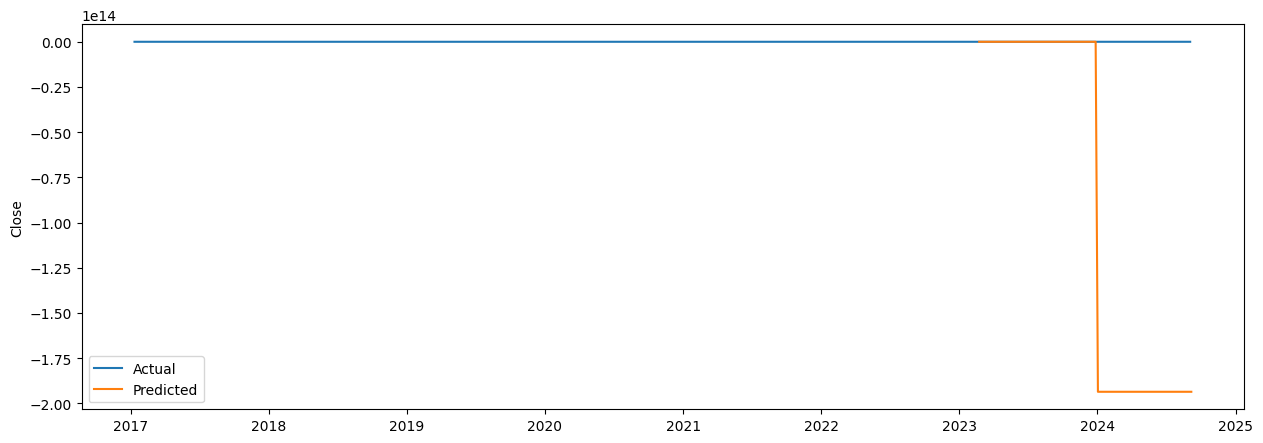

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)

model  = LinearRegression()
model.fit(scaler.transform(X_train), y_train)
y_pred = model.predict(scaler.transform(X_test))

print('RMSE :', mean_squared_error(y_test, y_pred, squared=True)**0.5)
# print('MAE :', mean_absolute_error(y_test, y_pred))
# print('MAPE :', mean_absolute_percentage_error(y_test, y_pred))
print('R2 :', r2_score(y_test, y_pred))

pred_df = pd.DataFrame({'Date': X_test.index.values, 'Predicted': y_pred})
pred_df.set_index('Date', inplace=True)

plt.figure(figsize=(15,5))
sns.lineplot(x=df_modeling.index.values,
             y=df_modeling['Close'],
             label='Actual')

sns.lineplot(x=pred_df.index.values,
             y=pred_df['Predicted'],
             label='Predicted')

# Workshop
### window = 7, step = 30

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf

data = yf.download('CPF.BK', start = "2017-01-01", end = "2024-09-09")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-04,29.75,30.00,29.50,29.50,24.02,28616300
2017-01-05,29.75,30.00,29.50,29.75,24.23,35396200
2017-01-06,30.00,30.75,29.75,30.25,24.63,63436500
2017-01-09,30.25,30.25,29.50,29.50,24.02,24732900
2017-01-10,29.50,30.25,29.50,30.25,24.63,28539700


In [ ]:
data.to_csv('CPF.csv')

In [ ]:
df_cpf = pd.read_csv('CPF.csv')
df_cpf.set_index('Date', inplace=True)

df_cpf.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-04,29.75,30.00,29.50,29.50,24.02,28616300
2017-01-05,29.75,30.00,29.50,29.75,24.23,35396200
2017-01-06,30.00,30.75,29.75,30.25,24.63,63436500
2017-01-09,30.25,30.25,29.50,29.50,24.02,24732900
2017-01-10,29.50,30.25,29.50,30.25,24.63,28539700


In [ ]:
df3 = df_cpf[['Close']]

In [ ]:
windows = 7
df_lagged = create_lagged_features(df3, windows=windows, step=1)
df_lagged.head()

,day_1,day_2,day_3,day_4,day_5,day_6,day_7,Close
Date,,,,,,,,
2017-01-16,29.50,29.75,30.25,29.50,30.25,29.75,30.00,29.50
2017-01-17,29.75,30.25,29.50,30.25,29.75,30.00,29.50,29.50
2017-01-18,30.25,29.50,30.25,29.75,30.00,29.50,29.50,29.25
2017-01-19,29.50,30.25,29.75,30.00,29.50,29.50,29.25,28.50
2017-01-20,30.25,29.75,30.00,29.50,29.50,29.25,28.50,28.50


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_lagged.drop('Close', axis=1),
    df_lagged['Close'], test_size=0.2,
    shuffle=False)

RMSE : 0.3355794417140114
R2 : 0.9687286319566253


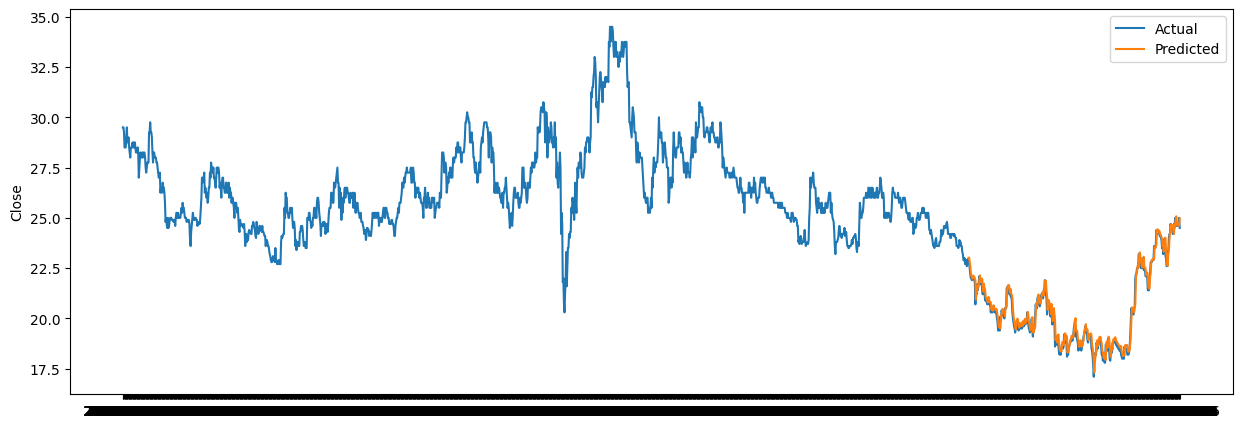

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)

model  = LinearRegression()
model.fit(scaler.transform(X_train), y_train)
y_pred = model.predict(scaler.transform(X_test))

print('RMSE :', mean_squared_error(y_test, y_pred, squared=True)**0.5)
# print('MAE :', mean_absolute_error(y_test, y_pred))
# print('MAPE :', mean_absolute_percentage_error(y_test, y_pred))
print('R2 :', r2_score(y_test, y_pred))

pred_df = pd.DataFrame({'Date': X_test.index.values, 'Predicted': y_pred})
pred_df.set_index('Date', inplace=True)

plt.figure(figsize=(15,5))
sns.lineplot(x=df_lagged.index.values,
             y=df_lagged['Close'],
             label='Actual')

sns.lineplot(x=pred_df.index.values,
             y=pred_df['Predicted'],
             label='Predicted')

plt.show()

In [ ]:
df3.tail(6)

,Close
Date,
2024-08-30,24.60
2024-09-02,24.60
2024-09-03,24.60
2024-09-04,24.60
2024-09-05,25.00
2024-09-06,24.50


In [ ]:
test = np.array([[24.60000038,24.60000038,24.60000038,24.60000038,25,24.5,25]])

In [ ]:
model.predict(scaler.transform(test))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([24.93915812])